# Projection of 3D Bounding Boxes onto 2D Image Plane


In this project, we visualize annotated 3D object bounding boxes by projecting them from world coordinates onto a 2D camera image. We use the camera's intrinsic and extrinsic parameters to transform and project each box, and overlay them on the image with color-coded labels and distance annotations. This helps in interpreting object localization and perception in real-world 3D scenes.

## Load the camera pose, intrinsics, and bounding box data



In [2]:
import numpy as np
import pandas as pd
import pickle
import json
from scipy.spatial.transform import Rotation as R

# Load camera intrinsics from JSON
with open("/content/intrinsics.json", "r") as f:
    intrinsics = json.load(f)

K = np.array([
    [intrinsics["fx"], 0, intrinsics["cx"]],
    [0, intrinsics["fy"], intrinsics["cy"]],
    [0, 0, 1]
])
print("Loaded intrinsic matrix K:\n", K)

# Load bounding boxes DataFrame from pickle file (00.pkl)
import gzip
with gzip.open("/content/bbox.pkl.gz", "rb") as f:
    bbox_df = pickle.load(f)

print("Loaded bounding boxes DataFrame head:")
print(bbox_df.head())

# Define camera pose (rotation and translation)
q = [0.65782, -0.64741, 0.28335, -0.2604]  # [w, x, y, z]
t = np.array([0.4089, 0.2613, 1.8091])     # translation vector

rotation = R.from_quat([q[1], q[2], q[3], q[0]])  # Convert to [x, y, z, w]
R_wc = rotation.as_matrix()

print("Rotation matrix (R_wc):\n", R_wc)
print("Translation vector (t):", t)


Loaded intrinsic matrix K:
 [[1.9700131e+03 0.0000000e+00 9.7000020e+02]
 [0.0000000e+00 1.9700091e+03 4.8329880e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Loaded bounding boxes DataFrame head:
                                   uuid                     label       yaw  \
0  2c4dbdea-845e-4d29-8a94-9c86feb536fe                       Car  2.380306   
1  0633a338-f50d-41ca-a387-3100f81bb251  Other Vehicle - Uncommon -0.784098   
2  a12c3f56-50b8-412f-99a1-0165f20b4c97                       Car  2.326787   
3  f0f8b0e1-010f-4c79-bf4d-275248e34e71                       Car  2.380306   
4  a16f6e88-6993-492c-a91e-1e111df9d314  Other Vehicle - Uncommon  0.804152   

   stationary  camera_used  position.x  position.y  position.z  dimensions.x  \
0        True            1      20.759      31.401       0.591         1.867   
1        True            3       4.823     -26.158       0.729         1.405   
2        True            4     -60.458     -37.423       0.934         2.104   
3  

## Generate the 3D box vertices for each object

In [4]:
def generate_3d_box_vertices(center, dimensions, yaw):
    # Box dimensions
    dx, dy, dz = dimensions / 2.0  # half-lengths

    # Define corners in local box frame (before rotation)
    corners = np.array([
        [ dx,  dy, -dz],
        [ dx, -dy, -dz],
        [-dx, -dy, -dz],
        [-dx,  dy, -dz],
        [ dx,  dy,  dz],
        [ dx, -dy,  dz],
        [-dx, -dy,  dz],
        [-dx,  dy,  dz],
    ])

    # Rotation matrix around z-axis (yaw)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)
    R_z = np.array([
        [cos_yaw, -sin_yaw, 0],
        [sin_yaw,  cos_yaw, 0],
        [0,             0, 1]
    ])

    # Rotate and translate corners to global frame
    rotated_corners = (R_z @ corners.T).T
    world_corners = rotated_corners + center

    return world_corners  # shape (8, 3)


## Project them onto the image plane

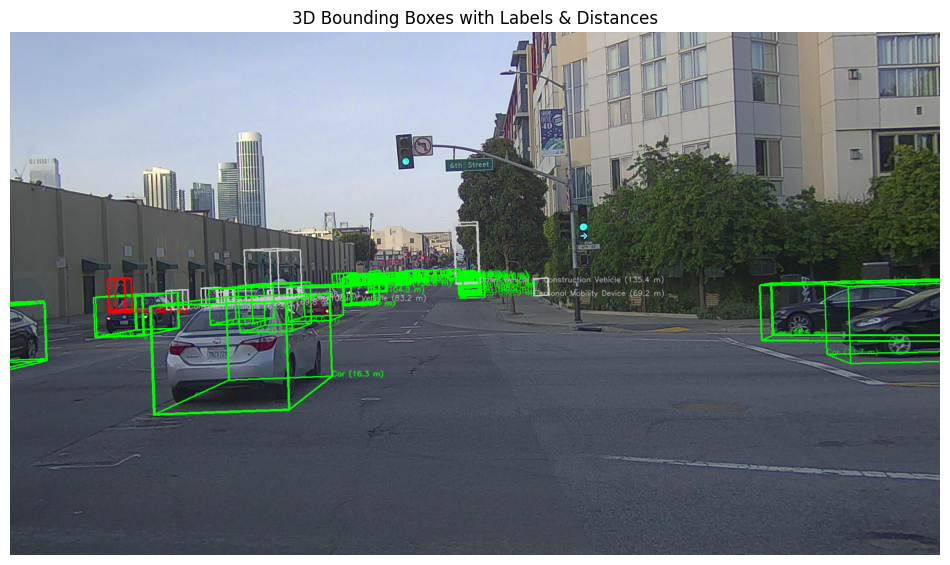

In [11]:
import cv2
import matplotlib.pyplot as plt

# Transpose R_wc to get R_cw (World to Camera)
R_cw = R_wc.T

# Load image
img = cv2.imread("/content/Q2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
output_img = img.copy()

# Define color map for object labels
label_colors = {
    'Car': (0, 255, 0),  # Green
    'Pedestrian': (255, 0, 0),  # Blue
    'Cyclist': (255, 255, 0),  # Cyan
    'Other Vehicle - Uncommon': (255, 165, 0),  # Orange
}

for idx, row in bbox_df.iterrows():

    # Extract box parameters
    center = np.array([row['position.x'], row['position.y'], row['position.z']])
    dimensions = np.array([row['dimensions.x'], row['dimensions.y'], row['dimensions.z']])
    yaw = row['yaw']
    label = row['label']

    # Generate 3D box in world
    box_3d_world = generate_3d_box_vertices(center, dimensions, yaw)

    # Transform to camera frame
    box_cam = (R_cw @ (box_3d_world - t).T).T

    # Skip boxes with any vertex behind camera
    if np.any(box_cam[:, 2] <= 0):
        continue

    # Project to 2D
    pixels = (K @ box_cam.T).T
    pixels /= pixels[:, 2:3]
    pixels = pixels[:, :2].astype(int)

    # Pick color based on label
    color = label_colors.get(label, (200, 200, 200))  # Default gray if unknown

    # Draw box edges
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    for i, j in edges:
        pt1 = tuple(pixels[i])
        pt2 = tuple(pixels[j])
        cv2.line(output_img, pt1, pt2, color=color, thickness=2)

    # Compute distance (Euclidean) from camera to object center
    center_cam = R_cw @ (center - t)
    distance = np.linalg.norm(center_cam)

    # Draw label + distance
    text = f"{label} ({distance:.1f} m)"
    text_pos = tuple(pixels[0])  # One corner of the box
    cv2.putText(output_img, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX,
                0.5, color, thickness=1, lineType=cv2.LINE_AA)

# Show result
plt.figure(figsize=(12, 8))
plt.imshow(output_img)
plt.title("3D Bounding Boxes with Labels & Distances")
plt.axis('off')
plt.show()
